/tmp/ipykernel_101971/3396804530.py:10: DtypeWarning: Columns (2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/zaccosenza/code/project-weather/data/01_raw/LGA_weather_data.csv")


Test MSE: 1.595


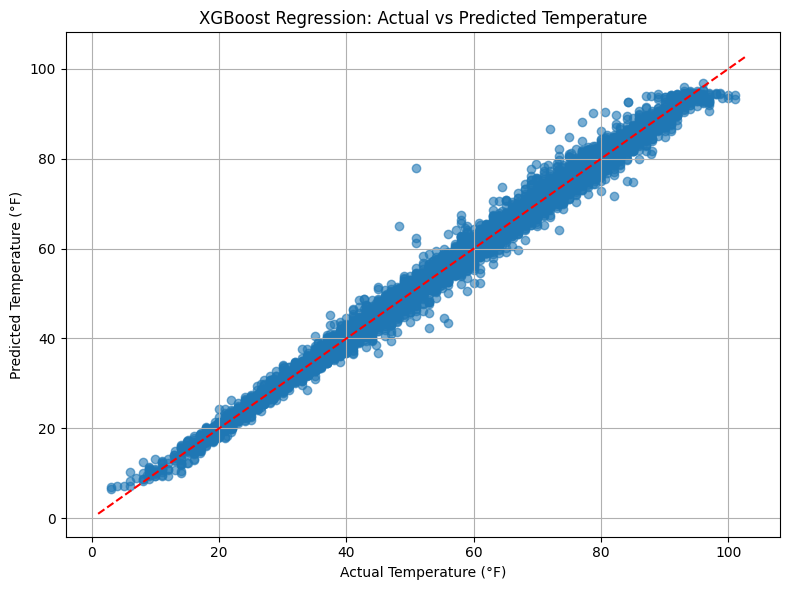

Saved average absolute error by (month, day, hour) to avg_abs_error_by_time.csv


In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load and preprocess
df = pd.read_csv("/home/zaccosenza/code/project-weather/data/01_raw/LGA_weather_data.csv")
df['valid'] = pd.to_datetime(df['valid'], errors='coerce')
df['tmpf'] = pd.to_numeric(df['tmpf'], errors='coerce')
df = df.dropna(subset=['valid', 'tmpf']).sort_values('valid')

# Extract time features
df['month'] = df['valid'].dt.month
df['day'] = df['valid'].dt.day
df['hour'] = df['valid'].dt.hour
df['temp'] = df['tmpf']

# Features and target (target is next hour's temperature)
X = df[['month', 'day', 'hour', 'temp']].iloc[:-1]
y = df['tmpf'].shift(-1).iloc[:-1]

# Train/test split (random, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train XGBoost regressor
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")

# # Save model
# with open("xgb_temp_model.pkl", "wb") as f:
#     pickle.dump(model, f)

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Temperature (°F)")
plt.ylabel("Predicted Temperature (°F)")
plt.title("XGBoost Regression: Actual vs Predicted Temperature")
plt.grid(True)
plt.tight_layout()
plt.savefig("xgb_temp_pred.png")
plt.show()

# Calculate and save errors by time
results_df = X_test.copy()
results_df['true_tmpf'] = y_test.values
results_df['pred_tmpf'] = y_pred
results_df['abs_error'] = np.abs(y_test - y_pred)

error_by_time = results_df.groupby(['month', 'day', 'hour'])['abs_error'].mean().reset_index()
error_by_time.to_csv("avg_abs_error_by_time.csv", index=False)
print("Saved average absolute error by (month, day, hour) to avg_abs_error_by_time.csv")
